# Functional model

In [230]:
#TODO: printing methods
#TODO: use Enums

In [217]:
# Simulations study parameters
FMIN = 6 #minimum possible visual score
SMIN = 0 #minimum possible symptom score
NDAYS = 160 #number of days in the study
FIRSTVISIT = 8
LASTVISIT = NDAYS-1

from warnings import warn
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors
from numpy import random
import numpy as np
random.seed(3) # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/

In [5]:
#helper functions

def uniform_to_normal(interval, pmsigma=3):
    '''
    Converts parameters for a uniform distribution to parameters for a normal distribution 

            Input:
                    interval (tuple of (float, float)): the interval boundaries (min and max)
                    pmsignma (float): half the standard deviations that the interval should comprise of
            Returns:
                    normal_params (tuple of (float, float)): mean and stdev
    '''
    mean = (interval[0]+interval[1])/2
    stdev = (interval[1]-interval[0])/(2*pmsigma)
    return (mean, stdev)

In [218]:
from types import MethodType

class Population:
    def __init__(self, size=10000, title=''):
        
        self.title = title
        self.size = size
        
        self.parameter_generators = {}
        self.parameters = {}
        self.function_generators = {}
        
        self.visualscores = None
        self.symptomscores_noerror = None
        self.symptomscores = None
        
    def set_parameter_generator(self, paramname, func, paramtype):
        '''
        func must be a numpy function with the "shape" argument of the numpy function as the only argument to func
        paramtype must be either "population", "person", or "day"
        '''
        if paramtype == 'population':
            shape = (1,)
        elif paramtype == 'person':
            shape = (self.size, 1)
        elif paramtype == 'day':
            shape = (self.size, NDAYS)
        self.parameter_generators[paramname] = lambda: func(shape)
        
    def generate_parameters(self):
        '''generates all parameters
        if population was already generated, is resets the scores (since they were based on previous parameters)
        '''
        #generate
        for paramname in self.parameter_generators.keys():
            self.parameters[paramname] = self.parameter_generators[paramname]()
        #reset
        self.visualscores = None
        self.symptomscores_noerror = None
        self.symptomscores = None
        
    def set_visualscore_generator(self, paramnames, func):
        '''
        paramnames must be an iterable of strings corresponding to some paramname added with self.set_parameter_generators()
        arguments of func must be time followed by params in the same order as corresponding paramnames
        '''
        self.function_generators['visualscore'] = (paramnames, func)
        
    def set_symptomscore_generator(self, paramnames, func):
        '''
        paramnames must be an iterable of strings corresponding to some paramname added with self.set_parameter_generators()
        arguments of func must be visualscore followed by params in the same order as corresponding paramnames
        '''
        self.function_generators['symptomscore'] = (paramnames, func)
        
    def set_error_generator(self, paramnames, func):
        '''
        paramnames must be an iterable of strings corresponding to some paramname added with self.set_parameter_generators()
        arguments of func must be symptomscore followed by params in the same order as corresponding paramnames
        '''
        self.function_generators['error'] = (paramnames, func)
        
    def generate_from_function_generator(self, generatorname):
        paramnames, func = self.function_generators[generatorname]
        paramvals = [self.parameters[paramname] for paramname in paramnames]
        return func(*paramvals)
        
    def generate(self, generate_parameters=True):
        if generate_parameters: self.generate_parameters()
        
        days = np.arange(NDAYS) #horizontal array
        persons = np.zeros((self.size, 1)) #to make sure we always get matrices
        
        paramnames, func = self.function_generators['visualscore']
        paramvals = [self.parameters[paramname] for paramname in paramnames]
        self.visualscores = persons + func(days, *paramvals)
        minscore = np.min(self.visualscores)
        if minscore < FMIN: 
            warn("visual score in {} has min={}, which is below FMIN={}".format(self.title, minscore, FMIN))
        
        paramnames, func = self.function_generators['symptomscore']
        paramvals = [self.parameters[paramname] for paramname in paramnames]
        self.symptomscores_noerror = persons + func(self.visualscores, *paramvals)
        
        paramnames, func = self.function_generators['error']
        paramvals = [self.parameters[paramname] for paramname in paramnames]
        self.symptomscores = persons + func(self.symptomscores_noerror, *paramvals)
        minscore = np.min(self.symptomscores)
        if minscore < SMIN: 
            warn("symptom score in {} has  min={}, which is below SMIN={}".format(self.title, minscore, SMIN))
    
    #TODO should have 'reserved' parameters like 'time', 'visualfunction', 'symptoms_noerror' which would still be put in arglist        
    
    def recalculate_size(self):
        #TODO try-catch for if not generated yet
        self.size = self.visualscores.shape[0]
        
    #removing outliers TODO rewrite
    def filter(self):
        def isTypicalRecovery(person):
            if (min(person.symptomscores[:FIRSTVISIT] <= SMIN)): #if at some point before first visit symptoms go to 'recovered'
                return False #person 'cancels the appointment
            elif (min(person.symptomscores) > SMIN): #if symptoms never go to 'recovered'
                return False #excluded from study because considered 'chronic'
            else:
                return True #typical patient
        filtered_pop = Population(0)
        filtered_pop.persons = filter(isTypicalRecovery, self.persons)
        filtered_pop.recalculate_size()
        return filtered_pop
    
    #plotting
    def plot(self, ax, ndays=NDAYS, npersons=None, score='symptom', viztype='lines'):
        #score is either 'symptom', 'visual', or 'symptom no error'
        #viztype is either 'lines', 'points', or 'both'
        
        if npersons is None: npersons=self.size
        
        if score=='visual':
            scores = self.visualscores[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='visual score')
        if score=='symptom no error':
            scores = self.symptomscores_noerror[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='symptom score without error')
        if score=='symptom':
            scores = self.symptomscores[:npersons, :ndays]
            ax.set(title=self.title, xlabel='days since concussion', ylabel='symptom score')
        
        colors = [mcolors.to_rgba(c) for c in plt.rcParams['axes.prop_cycle'].by_key()['color']] #list of 10 rgba colors
        if viztype=='lines' or viztype=='both':
            days = np.tile(np.arange(ndays), npersons).reshape((npersons, ndays))
            points = np.stack([days, scores], axis=2)
            ax.add_collection(LineCollection(points, colors=colors))
            ax.autoscale()
        if viztype=='points' or viztype=='both':
            days = np.tile(np.arange(ndays), npersons)
            edgecolors = np.repeat(colors[:npersons], ndays, axis=0)
            ax.scatter(days, scores.flatten(), facecolors='none', edgecolors=edgecolors)
            ax.autoscale()

In [201]:
# Various functions to create populations

def get_default_pop(size=10000):
    pop = Population(size, 'default pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_visualscore_generator(['r','f0'], gen_visualscores)
    gen_r = lambda shape: np.full(shape=shape, fill_value=1)
    pop.set_parameter_generator('r', gen_r , 'person')
    gen_f0 = lambda shape: np.full(shape=shape, fill_value=16)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_symptomscore_generator(['a'], gen_symptomscores)
    gen_a = lambda shape: np.full(shape=shape, fill_value=1)
    pop.set_parameter_generator('a', gen_a, 'population')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_error_generator(['C'], gen_error_mult)
    gen_C = lambda shape: np.full(shape=shape, fill_value=1)
    pop.set_parameter_generator('C', gen_C, 'day')

    return pop

def get_poster_pop(size=10000):
    pop = Population(size, 'poster pop')        

    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_visualscore_generator(['r','f0'], gen_visualscores)
    gen_r = lambda shape: 2
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: np.random.randint(14, 18+1, size=shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a,s0: np.maximum(a*f+s0, SMIN)
    pop.set_symptomscore_generator(['a', 's0'], gen_symptomscores)
    gen_a = lambda shape: 1
    pop.set_parameter_generator('a', gen_a, 'population')
    gen_s0 = lambda shape: np.random.normal(6, 2, size=shape)
    pop.set_parameter_generator('s0', gen_s0, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_error_generator(['C'], gen_error_mult)
    gen_C = lambda shape: 1 + np.random.choice([-1, 1], size=shape)*(np.random.randint(0, 30, size=shape)/100)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_prevsim_pop(size=10):
    pop = Population(size, 'previous simulation - basic pop')
    
    #visual score
    gen_visualscores = lambda t,r,f0: np.maximum(-r*t+f0, FMIN)
    pop.set_visualscore_generator(['r','f0'], gen_visualscores)
    gen_r = lambda shape: 1
    pop.set_parameter_generator('r', gen_r , 'population')
    gen_f0 = lambda shape: random.normal(*uniform_to_normal((14, 18)), shape)
    pop.set_parameter_generator('f0', gen_f0, 'person')

    #symptom score no error
    gen_symptomscores = lambda f,a: a*(f-FMIN)
    pop.set_symptomscore_generator(['a'], gen_symptomscores)
    gen_a = lambda shape: random.choice([1, 2, 3], shape)
    pop.set_parameter_generator('a', gen_a, 'person')

    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_error_generator(['C'], gen_error_mult)
    gen_C = lambda shape: random.normal(*uniform_to_normal((0.8, 1.2), pmsigma=3), shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_linpop(size=10000):
    pop = get_default_pop(size)
    pop.title = 'linear population with multiplicative error'
    
    #symptom error
    gen_error_mult = lambda s,C: s*C
    pop.set_error_generator(['C'], gen_error_mult)
    gen_C = lambda shape: random.normal(*uniform_to_normal((0.7, 1.3), pmsigma=3), size=shape)
    pop.set_parameter_generator('C', gen_C, 'day')
    
    return pop

def get_exppop(size=10000):
    pop = get_linpop(size)
    pop.title = 'exponential population with multiplicative error'
    
    #symptom score no error
    gen_symptomscores = lambda f,a,f0,B: a*(f0-FMIN)*(B**f-B**FMIN)/(B**f0-B**FMIN)
    pop.set_symptomscore_generator(['a', 'f0', 'B'], gen_symptomscores)
    gen_B = lambda shape: np.full(shape=shape, fill_value=1.5)
    pop.set_parameter_generator('B', gen_B, 'population')
    
    return pop

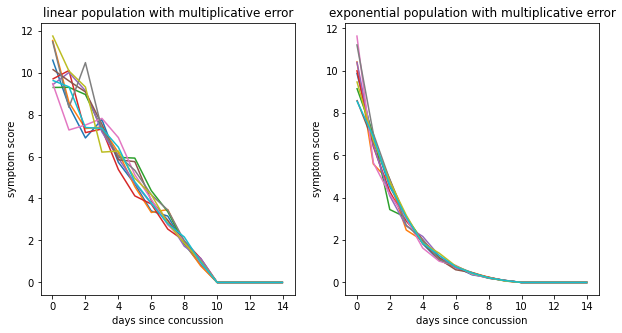

In [209]:
#TODO function to link parameters across populations (generate only once)
linpop = get_linpop(10)
exppop= get_exppop(size=linpop.size)
linpop.generate()
exppop.generate()

fig, axes = plt.subplots(ncols=2, figsize=plt.figaspect(1/2.0)*1.25)
ndays = 15
linpop.plot(axes[0], ndays=ndays)
exppop.plot(axes[1], ndays=ndays, score='symptom')

plt.show()

Intersting to note: the heterostatic error seems less pronounced for exponential symptoms. This is likely due to its large slope early on, as an increase of the same amount which is about -1 days for the linear will seem like much less time difference for exponential. The opposite is true later on, when the exponential curve is slower than the linear one.